In [0]:
# !pip install -q torch==1.1.0 torchvision
# written in python3

In [0]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import random
import math
import time

In [0]:
# torch version check
print("pytorch version:", torch.__version__)

# cuda check
if torch.cuda.is_available(): device = torch.device("cuda")
else: device = torch.device("cpu")
print("device:", device)

pytorch version: 1.1.0
device: cuda


In [0]:
# Define a transform to normalize the data
transform = transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = torchvision.datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)

# Download and load the test data
testset = torchvision.datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)

classes = ('T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

0it [00:00, ?it/s]

26427392it [00:04, 5951292.34it/s]                              


Extracting F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 37475.37it/s]                           
0it [00:00, ?it/s]

Extracting F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:02, 1880286.65it/s]                            
0it [00:00, ?it/s]

Extracting F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 16633.65it/s]            

Extracting F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Visualize some images

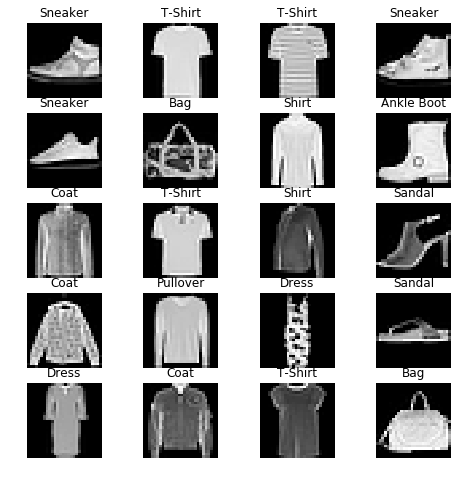

In [0]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(trainset));
    img = trainset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[trainset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

Construct following networks:


1.   Fully Connected Network



In [0]:
class FullyConnectedNetwork(nn.Module):
    
    # hidden_layer should be between 1 ~ 3
    def __init__(self, input_size= 28*28, hidden_size=1024, hidden_layer=2, output_size=10):
        super(FullyConnectedNetwork, self).__init__()
        
        self.hidden_layer = hidden_layer
        if hidden_layer == 1:
            self.fc1 = nn.Linear(input_size, output_size)
        elif hidden_layer == 2:
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, output_size)
        elif hidden_layer == 3:
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x) :
        # x: trainset
        
        if self.hidden_layer == 1:
            x = F.log_softmax(self.fc1(x), dim=1)
            return x
        elif self.hidden_layer == 2:
            x = F.relu(self.fc1(x))
            x = F.log_softmax(self.fc2(x), dim=1)
            return x
        elif self.hidden_layer == 3:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.log_softmax(self.fc3(x), dim=1)
            return x

2. LeNet (CNN)

In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.layer1 = nn.Sequential( nn.Conv2d(1, 6,  kernel_size=5, padding=2), nn.BatchNorm2d(6),  nn.ReLU(), nn.MaxPool2d(2))
        self.layer2 = nn.Sequential( nn.Conv2d(6, 16, kernel_size=5, padding=2), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2))
        self.fc1    = nn.Sequential( nn.Linear(7*7*16, 120), nn.ReLU())
        self.fc2    = nn.Sequential( nn.Linear(120, 84),     nn.ReLU())
        self.fc3    = nn.Sequential( nn.Linear(84, 10),      nn.ReLU())
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x

In [0]:
# model: either FCN(Fully Connected Network) or CNN (LeNet)
def train(MODEL, EPOCH=30, OPTIMIZER="SGD", LEARNING_RATE=0.001, LOSS_FUNCTION="CrossEntropy", MOMENTUM=0.9, WEIGHT_DECAY=0.0, BATCH_SIZE=100, SHOW_PROCESS=True):
    
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    
    if MODEL == "FCN":
        net = FullyConnectedNetwork()
    elif MODEL == "CNN":
        net = LeNet()
    
    if SHOW_PROCESS: print(net)
    
    # initialize optimizers
    # create a stochastic gradient descent optimizer
    if OPTIMIZER== "SGD":         
        optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    elif OPTIMIZER== "Adagrad":  
        optimizer = optim.Adagrad(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    elif OPTIMIZER== "Adadelta":  
        optimizer = optim.Adadelta(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    elif OPTIMIZER== "Adam": 
        optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    elif OPTIMIZER== "RMSprop": 
        optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        
    # create a loss function
    if LOSS_FUNCTION == "CrossEntropy": 
        criterion = nn.CrossEntropyLoss()
    elif LOSS_FUNCTION == "L1": 
        criterion = nn.L1Loss()
    elif LOSS_FUNCTION == "MSE": 
        criterion = nn.MSELoss() # squared L2 loss
    elif LOSS_FUNCTION == "NLL": 
        criterion = nn.NLLLoss()
    elif LOSS_FUNCTION == "KLD": 
        criterion = nn.KLDivLoss()
        
    losses = []       # for visualizing the loss
    running_time = 0  # for visualizing running time
    start_time = time.time() # for running time meausre
    
    epoch = range(EPOCH)
    for e in epoch:

        for batch_idx, (images, labels) in enumerate(trainloader, 0):

            # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
            if MODEL == "FCN": images = images.view(-1, 28*28)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        # end of inner for loop 
        
        # every end of the epoch
        # calcluate running time
        cur_time = time.time()
        elapsed_time = cur_time - start_time
        
        # append losses & time for plotting
        losses.append(loss.item())
        running_time += elapsed_time
        
        # print statistics
        if SHOW_PROCESS:
            print('Train Epoch:{:>3} | Loss: {:>.6f} | Elapsed Time: {:<5} seconds '.format(e,  loss.item(), round(elapsed_time, 2)))
        
        # reset variables for next loop
        start_time = time.time()

    # loss validation
    plt.xkcd()
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.plot(losses)
    plt.show()
    
    # running time summary
    print("Total running time:", round(running_time, 2), "seconds")
    print("Average running time per epoch:", round(running_time/EPOCH, 2), "seconds")
    
    return net
    
def test(NET, MODEL):
    
    testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
    
    net = NET
    
    correct = 0
    total = 0
    with torch.no_grad():
        for (images, labels) in testloader:
            
            # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
            if MODEL == "FCN": images = images.view(-1, 28*28)
            
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} test images: {:.6f}'.format(len(testset), round(100*correct/total, 8)))
    
    return round(100*correct/total, 4)

Task1 Main Body

In [0]:
FCN = train("FCN")
_ = test(FCN, "FCN")

FullyConnectedNetwork(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)
Train Epoch:  0 | Loss: 0.636269 | Elapsed Time: 8.91  seconds 
Train Epoch:  1 | Loss: 0.382775 | Elapsed Time: 9.15  seconds 
Train Epoch:  2 | Loss: 0.415235 | Elapsed Time: 9.24  seconds 
Train Epoch:  3 | Loss: 0.349660 | Elapsed Time: 9.27  seconds 
Train Epoch:  4 | Loss: 0.370639 | Elapsed Time: 9.39  seconds 
Train Epoch:  5 | Loss: 0.278645 | Elapsed Time: 11.23 seconds 
Train Epoch:  6 | Loss: 0.559820 | Elapsed Time: 9.2   seconds 
Train Epoch:  7 | Loss: 0.520429 | Elapsed Time: 9.3   seconds 
Train Epoch:  8 | Loss: 0.449955 | Elapsed Time: 9.26  seconds 
Train Epoch:  9 | Loss: 0.311175 | Elapsed Time: 9.31  seconds 
Train Epoch: 10 | Loss: 0.373190 | Elapsed Time: 9.67  seconds 
Train Epoch: 11 | Loss: 0.359227 | Elapsed Time: 9.72  seconds 
Train Epoch: 12 | Loss: 0.311490 | Elapsed Time: 9.8   seconds 
Train Epoch: 13 | 

In [0]:
CNN = train("CNN")
_ = test(CNN, "CNN")

Task2 Main Body

1. Adjust Optimizer Parameters



A. Learning Rate

In [0]:
learning_rate_list = [1e-05, 1e-04, 1e-03, 0.01, 0.1]
for l in learning_rate_list:
    print("----------------------- Learnig Rate:", l, "-----------------------")
    CNN = train("CNN", LEARNING_RATE=l, SHOW_PROCESS=False)
    _ = test(CNN, "CNN")

B.   Momentum

In [0]:
momentum_list = [0, 0.3, 0.6, 0.9, 1.0]
for m in momentum_list:
    print("----------------------- Momentum:", m, "-----------------------")    
    CNN = train("CNN", MOMENTUM=m, SHOW_PROCESS=False)
    _ = test(CNN, "CNN")

C.   L2 Regularization Penalty

In [0]:
weight_decay_list = [0, 1e-05, 1e-04, 1e-03, 0.01]
for w in weight_decay_list:
    print("----------------------- L2 Regularization:", w, "-----------------------")    
    CNN = train("CNN", WEIGHT_DECAY=w, SHOW_PROCESS=False)
    _ = test(CNN, "CNN")

2. Try Different Loss Function

In [0]:
loss_function_list = ["CrossEntropy", "L1", "MSE", "NLL", "KLD"]
for l in loss_function_list:
    print("----------------------- Loss Function:", l, "-----------------------")
    CNN = train("CNN", LOSS_FUNCTION=l, SHOW_PROCESS=False)
    _ = test(CNN, "CNN")

3. Use Different Batch Size

In [0]:
batch_size_list = [32, 64, 128, 256, 512]
for b in batch_size_list:
    print("----------------------- Batch Size:", b, "-----------------------")
    CNN = train("CNN", BATCH_SIZE=b, SHOW_PROCESS=False)
    _ = test(CNN, "CNN")

4. Change Other hyper parameters and model elements

In my case, I tried to try different optimizers

In [0]:
optimizer_list = ["SGD", "Adagrad", "Adadelta", "Adam", "RMSprop"]
for o in optimizer_list:
    print("----------------------- Batch Size:", o, "-----------------------")
    CNN = train("CNN", OPTIMIZER=o, SHOW_PROCESS=False)
    _ = test(CNN, "CNN")